# TP: Datascience pour la finance

### Problème de Merton

On a un actif $S_A$ qui se modélise par l'équation suivante :

$$ dS_A = \sigma \; S_A \; dW_A $$

Pour cet exercice on utilise la fonction d'utilité suivante :
$$
U(X) = 1-e^{-X}
$$

On fait l'hypothèse que la stratégie optimale est une fonction polynomiale de degré au plus D.
La stratégie $\alpha$ consiste à :
- Initialisation : acheter $\alpha (0)$ en $T=0 $
- En $T=n$ avec $n\geq 1$ : On vend $\alpha (n-1) $ et on achète $\alpha(n) $ tel que 
$$
\alpha(n) = \sum_{0 \leq k\leq D} \alpha^{(k)}(n) \; (S_{T_n})^k
$$

La fonction $V$ représente notre richesse en fonction du temps $T_N$, par rapport a notre stratégie $\alpha$:
$$
V^{\alpha,D}(T_N) = \sum_{i=0}^{N-1}  \alpha(i) \; (S_{T_{i+1}} - S_{T_i}) + \mathbb{1}_{S_{T_N} \geq K}
$$

On cherche la stratégie qui maximise notre fonction d'utilité, i.e, on résoud le problème suivant :

$$
 \max_{\alpha} \mathbb{E} [ U(V^{\alpha,D}(T_n)) ]
$$


### Simulation du processus 

On prend comme hypothèse que :
- $S_0 = 100$
- $N = 100$
- $\sigma = 10 \%$
- $K = [80-120] $
- $r=0$

On simule le processus du sous-jacent par la formule suivante:

$$ S_T = S_0 \cdot \exp  ( -\frac{\sigma^2}{2}\cdot T + \sigma W_T )  $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import random

%matplotlib inline

In [52]:
S0 = 10
N = 10
sigma = 0.1
T = np.linspace(0,1,100)

def Brownian_Motion(n,N,sigma):
    """
    - n représente le nombre de données que l'on veut générer pour l'échantillon
    - N est la longueur de notre mouvement brownien.
    - sigma représente l'écart-type.
    On retroune W la matrice des n mouvements browniens.
    """
    G = np.random.normal(loc = 0,scale = sigma,size = (n,N))
    zeros = np.zeros(n).reshape(n,1)
    W = np.concatenate((zeros,np.cumsum(G,axis = 1)),axis=1)
    return W

def S_t(S0=S0, N=N,sigma=sigma,n=10):
    """
    - S0 représente la première valeur de notre courbe de taux que l'on simule
    On retourne n simulations de la courbe de taux décrite par l'EDP (1).
    """
    return np.multiply(np.repeat(S0,n).reshape(n,1),np.exp(-0.5*sigma**2*np.arange(N+1)/(N+1)+sigma*Brownian_Motion(n,N,sigma))).T

On génère un échantillon de données 

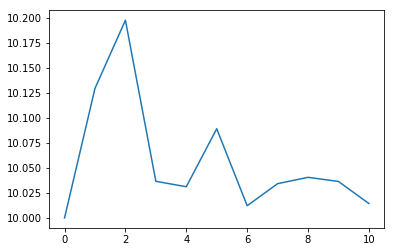

In [53]:
np.random.seed(10)

S = S_t(S0=S0,N=N,sigma = sigma ,n=1)
plt.plot(S)



## Algorithme stochastique

On applique une descente de gradient pour trouver le $\alpha^{\star}$. Le principe est d'initialiser les paramètres à des valeurs quelconques puis de se rapprocher de la solution en itérant dans le sens inverse du gradient:
$$
\alpha_{i+1}(T_n) = \alpha_i(T_n) -  \theta_n\cdot\nabla_{\alpha_i} U(V^{\alpha,D}(T_n))
$$

avec $\nabla_{\alpha_i} U(V^{\alpha,D}(T_n)) = \frac{\partial U(V^{\alpha,D})}{\partial \alpha_i}(\cdot) $, la dérivée partiel par rapport au paramètre à optimiser et $\theta_n$ est le pas de descente.

Dans notre cas on va choisir $\theta_n = 1/n$.

###### Petit rappel de calcul des dérivées :

$$
    (f(g(x)))^{\prime} = g^{\prime}(x)\times f^{\prime}(g(x))
$$

Un petit rappel de l'énoncé:
$$
    V^{\alpha,D}(T_N) = \sum_{i=0}^{N-1}  \alpha(i) \; (S_{T_{i+1}} - S_{T_i}) + \mathbb{1}_{S_{T_N} \geq K}
$$
Donc, on a
$$
    \nabla_{\alpha_i} U(V^{\alpha,D}(T_i)) = 
    \left \{
   \begin{array}{r l}
      \exp(-V^{\alpha,D}(0))\cdot (S(T_1)-S(0)) & \text{ si } T_i = 0 \\
      \exp(-V^{\alpha,D}(T_i))\cdot (S(T_{i+1})-S(T_i)) & \text{ si } T_i > 0 \text{ et } k=0 \\
      \exp(-V^{\alpha,D}(T_i)) \cdot (S_{T_i})^k\cdot (S(T_{i+1})-S(T_i)) & \text{ sinon } 
   \end{array}
   \right .
$$




In [54]:
def parameters_alpha(alpha,S,D):
    return np.r_[alpha[0],np.diag(alpha[1::].reshape(len(S)-1,-1).dot(np.array([S[1:(len(S)-1)]**i for i in range(D+1)]).reshape(D+1,-1)))]

def V(alpha,S,D,k):
    return np.r_[alpha[0]*S[0], np.repeat(np.cumsum(parameters_alpha(alpha,S,D)[0:(len(S)-1)]*(S[1::]-S[0:(len(S)-1)]).ravel()).ravel(),D+1)]+np.repeat((S>k).ravel(),D+1)[D::]


In [55]:
def gradient_descent(alpha,S,learning_rate,D,k):
    """
    - alpha sont les paramètres a optimiser
    - S le processus stochastique
    - learning_rate le pas de descente
    - D le degré des polynomes alpha
    On retourne le gradient et les nouveaux parmaètres après une itération.
    """
    grads = np.exp(-V(alpha ,S[0:(len(S)-1)] ,D ,k))*np.r_[S[1]-S[0],np.multiply(np.array([S[1:(len(S)-1)]**i for i in range(D+1)]),S[2:]-S[1:(len(S)-1)]).T.ravel()]
    alpha -= learning_rate * grads
    return (grads,alpha)


In [56]:
def optimization(alpha, S, learning_rate,D,k, num_iteration):
    """
    - alpha sont les paramètres a optimiser
    - S le processus stochastique
    - learning_rate le pas de descente
    - D le degré des polynomes alpha
    On applique la descente de gradient pour un certain nombre d'itération et on retourne les paramètres optimisés.
    """
    for i in range(num_iteration):
        grads,alpha = gradient_descent(alpha,S,learning_rate/num_iteration,D,k)
    return alpha

In [71]:
D=0
alpha = np.ones((D+1)*(N-1)+1).ravel()
print(V(alpha,S[0:(len(S)-1)],D,6))

grads, alpha = gradient_descent(alpha,S,learning_rate=1,D=D,k=6)

print(grads,alpha)

[11.          1.12944382  1.19752105  1.03657689  1.03117481  1.08910914
  1.01216784  1.03422458  1.04055757  1.03642542]
[ 2.16193196e-06  2.20034449e-02 -4.85957691e-02 -1.91593689e-03
  2.06586745e-02 -2.58919876e-02  8.01608687e-03  2.25138997e-03
 -1.45971565e-03 -7.82561046e-03] [0.99999784 0.97799656 1.04859577 1.00191594 0.97934133 1.02589199
 0.99198391 0.99774861 1.00145972 1.00782561]


In [72]:
print(optimization(alpha,S,learning_rate=1,D=D,k=S0+1,num_iteration=100))

[0.99999196 0.91818495 1.18115788 1.00723939 0.92193952 1.09803984
 0.96954099 0.99144265 1.0055484  1.02974556]


## Reseau de neurones 

Le but du réseau de neurone est de maximiser une fonction d'energie. Dans notre cas c'est la fonction d'utilité. On lui donne la courbe de l'actif sur lequel on cherche la stratégie optimale et le reseau de neurone cherche les paramètres optimaux $\alpha^{\star}$.

<img src="NN.png">

Pour construire un réseau de neurones on réalise plusieurs fonctions. 
La première est celle de l'initialisation des paramètres que l'on cherche à optimiser avec le réseau de neurone.
On rappel que les paramètres à optimiser s'exprime de la manière suivante :

$$ 
    \alpha(i) = \left \{
   \begin{array}{r l}
      \alpha(0) & \text{ si } i = 0 \\
      \sum_{0 \leq k\leq D} \alpha^{(k)}(i) \; (S_{T_i})^k & \text{ si } i > 0 
   \end{array}
   \right .
$$




### Initialisation du réseau de neurone

In [73]:
def Initialisation(N,D):
    """
    On initialise les paramètres.
    - N : Nombre de Dates où l'on optimise notre quantité d'actif
    - D : Le degrée du polynôme de la quantité d'actif
    """
    a = np.ones((D+1)*(N-1)+1)
    
    return a

In [74]:
a  = Initialisation(N,D)

print("dimension de a = "+str(a.shape))

dimension de a = (10,)


### La propagation et rétropropagation 

Cette étape permet d'atapter la descente de gradient à la structure du neurone. 

In [75]:
def compute_propagation(alpha,S,N,D,k):
    """
    - alpha : paramètres à optimiser
    - S : courbe de l'actif
    - N : Date à laquelle on fait les échanges
    - D : Degrée de polynome pour approcher la stratégie optimale
    """
    # foward propagation 
    U = 1-np.exp(-V(alpha,S[0:(len(S)-1)],D,k))
    
    # backward propagation
    grads = np.exp(-V(alpha ,S[0:(len(S)-1)] ,D ,k))*np.r_[S[1]-S[0],np.multiply(np.array([S[1:(len(S)-1)]**i for i in range(D+1)]),S[2:]-S[1:(len(S)-1)]).T.ravel()]
    
    return grads, U

In [76]:
def compute_neural_network(S,N,D,k, num_iterations, learning_rate=1):
    alpha = Initialisation(N,D)
    utilite = []
    for i in range(num_iterations):
        grads, U = compute_propagation(alpha,S,N,D,k)
        
        # update parameters
        alpha = alpha - (learning_rate/(i+1))*grads
        
        if i %100 == 0:
            utilite.append(U[-1])
            print(U[-1])
    return alpha, grads, utilite

In [77]:
alpha,grads,utilite = compute_neural_network(S,N,D,6, 1000, 1)

0.6452796045122907
0.6208664583370982
0.617452509797519
0.6154339221339203
0.6139924854736307
0.6128692422247652
0.6119481594349694
0.6111670742640888
0.6104887546115025
0.609889117296054


## Fonction Utilité : $U(X)=X^2$

In [81]:
def gradient_descent(alpha,S,learning_rate,D,k):
    """
    - alpha sont les paramètres a optimiser
    - S le processus stochastique
    - learning_rate le pas de descente
    - D le degré des polynomes alpha
    On retourne le gradient et les nouveaux parmaètres après une itération.
    """
    grads = 2*V(alpha ,S[0:(len(S)-1)] ,D ,k)*np.r_[S[1]-S[0],np.multiply(np.array([S[1:(len(S)-1)]**i for i in range(D+1)]),S[2:]-S[1:(len(S)-1)]).T.ravel()]
    alpha -= learning_rate * grads
    return (grads,alpha)

In [83]:
D=3
alpha = np.ones((D+1)*(N-1)+1).ravel()
print(V(alpha,S[0:(len(S)-1)],D,6))

grads, alpha = gradient_descent_2(alpha,S,learning_rate=1,D=D,k=6)

print(grads,alpha)

[  11.            1.12944382    1.12944382    1.12944382    1.12944382
   79.62746811   79.62746811   79.62746811   79.62746811 -109.58194336
 -109.58194336 -109.58194336 -109.58194336 -115.64730267 -115.64730267
 -115.64730267 -115.64730267  -50.70076035  -50.70076035  -50.70076035
  -50.70076035 -138.40236176 -138.40236176 -138.40236176 -138.40236176
 -113.81107138 -113.81107138 -113.81107138 -113.81107138 -106.70531522
 -106.70531522 -106.70531522 -106.70531522 -111.35014763 -111.35014763
 -111.35014763 -111.35014763]
[ 2.84776406e+00  1.53778822e-01  1.55769394e+00  1.57785732e+01
  1.59828171e+02 -2.56311533e+01 -2.61374226e+02 -2.66536917e+03
 -2.71801582e+04  1.18394033e+00  1.18827081e+01  1.19261714e+02
  1.19697936e+03 -1.33998978e+01 -1.34416717e+02 -1.34835759e+03
 -1.35256107e+04  7.80196410e+00  7.87148672e+01  7.94162886e+02
  8.01239603e+03 -6.10540982e+00 -6.11283879e+01 -6.12027680e+02
 -6.12772386e+03 -1.44152860e+00 -1.44646217e+01 -1.45141263e+02
 -1.45638003e+03  

In [84]:
print(optimization(alpha,S,learning_rate=1,D=D,k=S0+1,num_iteration=100))

[-1.34122546e-01  8.57887176e-01 -4.39523871e-01 -1.35815762e+01
 -1.46703257e+02 -3.43111269e+03 -3.49980414e+04 -3.56902461e+05
 -3.63952956e+06  3.37049553e+06  3.38282285e+07  3.39519607e+08
  3.40761463e+09  6.75382199e+08  6.77487689e+09  6.79599744e+10
  6.81718383e+11  1.46983222e+12  1.48292977e+13  1.49614402e+14
  1.50947603e+15  9.95683818e+14  9.96895350e+15  9.98108357e+16
  9.99322840e+17 -4.33771119e+16 -4.35255683e+17 -4.36745327e+18
 -4.38240070e+19 -2.77038669e+17 -2.78162271e+18 -2.79290430e+19
 -2.80423164e+20  4.31967119e+18  4.33540577e+19  4.35119767e+20
  4.36704709e+21]


In [86]:
def compute_propagation(alpha,S,N,D,k):
    """
    - alpha : paramètres à optimiser
    - S : courbe de l'actif
    - N : Date à laquelle on fait les échanges
    - D : Degrée de polynome pour approcher la stratégie optimale
    """
    # foward propagation 
    U = (V(alpha,S[0:(len(S)-1)],D,k))**2
    
    # backward propagation
    grads = 2*V(alpha ,S[0:(len(S)-1)] ,D ,k)*np.r_[S[1]-S[0],np.multiply(np.array([S[1:(len(S)-1)]**i for i in range(D+1)]),S[2:]-S[1:(len(S)-1)]).T.ravel()]
    
    return grads, U

In [87]:
alpha,grads,utilite = compute_neural_network(S,N,D,6, 1000, 1)

12398.855378035942
6.484829051293037e+50
9.614561185022915e+51
3.752268719688901e+52
9.147523338960497e+52
1.7596334730772612e+53
2.9387872761525255e+53
4.471037089952552e+53
6.368576332945101e+53
8.639092941889934e+53
